In [1]:
# check which kernel we are using
!which python

/home/quirin/anaconda3/envs/skl/bin/python


## First steps

When it is online, [ProThermDB](https://web.iitm.ac.in/bioinfo2/prothermdb/index.html) can be scraped as a `31.526×42` table of `38.8MB` as a `.TSV` table if you (*e.g.*) request all entries matching `pH = 0:14`. 
[MPTherm](https://www.iitm.ac.in/bioinfo/mptherm/search.php) is smaller, containing `7202(×42)` records. It returns the entire database for `Organism = ' '`.

Maria prepared two datasets (*$\rightarrow$ full set* and *$\rightarrow$ redundancy-reduced set*) for three different measurements already: 

> $\Delta T_{m}$: change in melting temperature
>
> $\Delta\Delta G$: change in Gibbs Free energy of the protein, i.e. energy necessary to unfold the structure. 
>> "*If ddG is positive, the mutated protein is less stable than the wild type, which means a higher likelihood of a loss of function in the mutant; conversely, a negative ddG suggests that the structure is more stable pointing to the possibility of overstabilisation, i.e. preventing biologically relevant conformational changes.*" Zaucha et al. 2020
>>
>> $-1.0 \leq \Delta\Delta G \leq 1.0$ are 'neutral' variants, which only subtly perturb the protein structure
>>
>> $[kcal/mol]$
>
> $\Delta\Delta G_{H_{2}O}$: change in Free Energy for unfolding in water

I got six `.FASTA` files (two per measurement and three per dataset) with protein sequence data and header annotations in canonical UniPort format, as well as three per-measurement `.TSV` files of annotations.

First, try BioPython and RegEx parsing of `.FASTA` headers.

In [1]:
from Bio import SeqIO
from pathlib import Path
import re
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys
import numpy as np

In [19]:
wd = Path('.').resolve().parent
for fasta in wd.rglob('*.fasta'):
    for record in SeqIO.parse(fasta, 'fasta'):
#        pass
        print(record.description)
        break
    break
    
record.seq

sp|P00889|CISY_PIG Citrate synthase, mitochondrial OS=Sus scrofa OX=9823 GN=CS PE=1 SV=2


Seq('MALLTAAARLFGAKNASCLVLAARHASASSTNLKDILADLIPKEQARIKTFRQQ...DSK')

In [12]:
!find .. -name '*.fasta'

../reduced_set/uniprot_prothermdb_melttemp_rep_seq.fasta
../reduced_set/uniprot_prothermdb_delta_g_rep_seq.fasta
../reduced_set/uniprot_prothermdb_delta_g_h2o_rep_seq.fasta
../full_set/uniprot_prothermdb_delta_g.fasta
../full_set/uniprot_prothermdb_melttemp.fasta
../full_set/uniprot_prothermdb_delta_g_h2o.fasta


In [13]:
!cat ../**/*.fasta | grep ">" > headers.txt
!head headers.txt

>sp|P02625|PRVA_RAT Parvalbumin alpha OS=Rattus norvegicus OX=10116 GN=Pvalb PE=1 SV=2
>sp|P00711|LALBA_BOVIN Alpha-lactalbumin OS=Bos taurus OX=9913 GN=LALBA PE=1 SV=2
>sp|P0A877|TRPA_ECOLI Tryptophan synthase alpha chain OS=Escherichia coli (strain K12) OX=83333 GN=trpA PE=1 SV=1
>sp|P00171|CYB5_BOVIN Cytochrome b5 OS=Bos taurus OX=9913 GN=CYB5A PE=1 SV=3
>sp|P00651|RNT1_ASPOR Guanyl-specific ribonuclease T1 OS=Aspergillus oryzae (strain ATCC 42149 / RIB 40) OX=510516 GN=rntA PE=1 SV=2
>sp|P0AFG6|ODO2_ECOLI Dihydrolipoyllysine-residue succinyltransferase component of 2-oxoglutarate dehydrogenase complex OS=Escherichia coli (strain K12) OX=83333 GN=sucB PE=1 SV=2
>sp|P07751|SPTN1_CHICK Spectrin alpha chain, non-erythrocytic 1 OS=Gallus gallus OX=9031 GN=SPTAN1 PE=1 SV=3
>tr|O61594|O61594_SPOFR Beta-glucosidase OS=Spodoptera frugiperda OX=7108 PE=1 SV=1
>sp|P61626|LYSC_HUMAN Lysozyme C OS=Homo sapiens OX=9606 GN=LYZ PE=1 SV=1
>sp|Q13526|PIN1_HUMAN Peptidyl-prolyl cis-trans isomerase NI

Testing the RegEx at https://regex101.com/r/wnT73m/3

In [14]:
regex = re.compile('(?P<db>(?:sp|tr))\|(?P<accession>.+?)\|(?P<name>\S+?) (?P<full_name>.+?) OS=(?P<organism>.+?) OX=(?P<taxon_id>.+?) (GN=(?P<gene>.+?) )?PE=(?P<evidence_level>.+?) SV=(?P<version>.+?)$')
regex

re.compile(r'(?P<db>(?:sp|tr))\|(?P<accession>.+?)\|(?P<name>\S+?) (?P<full_name>.+?) OS=(?P<organism>.+?) OX=(?P<taxon_id>.+?) (GN=(?P<gene>.+?) )?PE=(?P<evidence_level>.+?) SV=(?P<version>.+?)$',
re.UNICODE)

In [15]:
for fasta in wd.rglob('*.fasta'):
    for record in SeqIO.parse(fasta, 'fasta'):
        break
    break
    
print(record.description)
m = regex.match(record.description)

sp|P00889|CISY_PIG Citrate synthase, mitochondrial OS=Sus scrofa OX=9823 GN=CS PE=1 SV=2


In [16]:
m.groupdict()

{'db': 'sp',
 'accession': 'P00889',
 'name': 'CISY_PIG',
 'full_name': 'Citrate synthase, mitochondrial',
 'organism': 'Sus scrofa',
 'taxon_id': '9823',
 'gene': 'CS',
 'evidence_level': '1',
 'version': '2'}

In [17]:
record.annotations = m.groupdict()
print(record)
dir(record.seq)

ID: sp|P00889|CISY_PIG
Name: sp|P00889|CISY_PIG
Description: sp|P00889|CISY_PIG Citrate synthase, mitochondrial OS=Sus scrofa OX=9823 GN=CS PE=1 SV=2
Number of features: 0
/db=sp
/accession=P00889
/name=CISY_PIG
/full_name=Citrate synthase, mitochondrial
/organism=Sus scrofa
/taxon_id=9823
/gene=CS
/evidence_level=1
/version=2
Seq('MALLTAAARLFGAKNASCLVLAARHASASSTNLKDILADLIPKEQARIKTFRQQ...DSK')


['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_data',
 'back_transcribe',
 'complement',
 'complement_rna',
 'count',
 'count_overlap',
 'encode',
 'endswith',
 'find',
 'index',
 'join',
 'lower',
 'lstrip',
 'reverse_complement',
 'reverse_complement_rna',
 'rfind',
 'rindex',
 'rsplit',
 'rstrip',
 'split',
 'startswith',
 'strip',
 'tomutable',
 'transcribe',
 'translate',
 'ungap',
 'upper']

Try out path regex here https://regex101.com/r/zjRWrx/1

In [18]:
path_regex = re.compile(r'.*?_prothermdb_(?P<measure>.+?)(?:(?:_)?(?P<dataset>rep_seq|a?)?\.fasta|\.tsv)')
path_regex

re.compile(r'.*?_prothermdb_(?P<measure>.+?)(?:(?:_)?(?P<dataset>rep_seq|a?)?\.fasta|\.tsv)',
re.UNICODE)

In [20]:

for ext in ['fasta', 'tsv']:
    for file in wd.rglob('*.%s' % ext):
        match = path_regex.match(file.name)
        assert match
        print(match.groupdict())


{'measure': 'melttemp', 'dataset': 'rep_seq'}
{'measure': 'delta_g', 'dataset': 'rep_seq'}
{'measure': 'delta_g_h2o', 'dataset': 'rep_seq'}
{'measure': 'delta_g', 'dataset': ''}
{'measure': 'melttemp', 'dataset': ''}
{'measure': 'delta_g_h2o', 'dataset': ''}
{'measure': 'delta_g_h2o', 'dataset': None}
{'measure': 'melttemp', 'dataset': None}
{'measure': 'delta_g', 'dataset': None}


In [23]:
seq_data = dict()

for fasta in wd.rglob('*.fasta'):
    gd = path_regex.match(fasta.name).groupdict()
    assert gd
    key = 'full' if not gd['dataset'] else gd['dataset'] , gd['measure']
    
    seq_data[key] = dict()
    for record in SeqIO.parse(fasta, 'fasta'):
        m = regex.match(record.description)
        assert m
        record.annotations = m.groupdict()
        record.id = record.annotations['accession']  # use the UniProt accession as id, as in ProtTherm
        
        assert record.id not in seq_data[key], '%s already observed\n' % record.id
        seq_data[key][record.id] = record

In [24]:
{str(fasta): len(d) for fasta, d in seq_data.items()}

{"('rep_seq', 'melttemp')": 204,
 "('rep_seq', 'delta_g')": 74,
 "('rep_seq', 'delta_g_h2o')": 147,
 "('full', 'delta_g')": 89,
 "('full', 'melttemp')": 255,
 "('full', 'delta_g_h2o')": 174}

In [25]:
keys = sorted(seq_data.keys())
keys

[('full', 'delta_g'),
 ('full', 'delta_g_h2o'),
 ('full', 'melttemp'),
 ('rep_seq', 'delta_g'),
 ('rep_seq', 'delta_g_h2o'),
 ('rep_seq', 'melttemp')]

Let's check whether the sequence data contains mutations

In [26]:
for i, j in zip([0,1,2], [3,4,5]):
    full = seq_data[keys[i]]
    partial = seq_data[keys[j]]
    shared = set(full.keys()).intersection(set(partial.keys()))
    assert all(full[_id].seq == partial[_id].seq for _id in shared)

All the given `.FASTA` sequences are identical across conditions, *i.e.* do not contain mutations.

In [27]:
dfs = {path_regex.match(tsv.name).groupdict()['measure']:
           pd.read_csv(tsv, sep='\t') for tsv in wd.rglob('*.tsv')}
dfs.keys()

dict_keys(['delta_g_h2o', 'melttemp', 'delta_g'])

In [28]:
# run this cell until KeyError: 'popitem(): dictionary is empty' to ensure all dataframes are ok
path, df = dfs.popitem()
df

,UniProt_ID,MUTATION,pH,T_(C),MEASURE,METHOD,∆Tm_(C),∆∆G_(kcal/mol),∆∆G_H2O_(kcal/mol)
0,P00720,R96H (Based on UniProt and PDB),3.0,-,CD,Thermal,-13.6,-3.3,-
1,P00720,M102V (Based on UniProt and PDB),3.0,-,CD,Thermal,-12.7,-3,-
2,P00720,W138Y (Based on UniProt and PDB),2.2,-,CD,Thermal,-6.3,-1.71,-
3,P00720,W138Y W126Y W158Y (Based on UniProt and PDB),2.2,-,CD,Thermal,-6.6,-1.82,-
4,P00720,W138Y W126Y W158Y (Based on UniProt and PDB),2.5,-,CD,Thermal,-6.2,-1.77,-
...,...,...,...,...,...,...,...,...,...
3178,P04637,C242S (Based on UniProt and PDB),7.2,10,Fluorescence,Urea,-,-2.94,-2.94
3179,P04637,R248Q (Based on UniProt and PDB),7.2,10,Fluorescence,Urea,-,-1.94,-1.94
3180,P04637,R249S (Based on UniProt and PDB),7.2,10,Fluorescence,Urea,-,-1.95,-1.95
3181,P04637,R273H (Based on UniProt and PDB),7.2,10,Fluorescence,Urea,-,-0.35,-0.35


In [29]:
path

'delta_g'

In [38]:
dfs = dict()
dfs = {path_regex.match(tsv.name).groupdict()['measure']:
           pd.read_csv(tsv, sep='\t') for tsv in wd.rglob('*.tsv')}

cols = lambda i: list(dfs[list(dfs.keys())[i]].columns)
assert cols(0) == cols(1) and cols(1) == cols(2), 'the dataframe colums are not identical'

conditions = list(dfs.keys())
for c in conditions:
    # pop to avoid pandas warnings
    df = dfs.pop(c)
    # filter out rows with undetermined '-' or 'wild-type' mutation
    df = df.loc[(df.MUTATION != '-') & (df.MUTATION != 'wild-type')]
    # split the mutation column'R191A K1943'
    df[['MUTATION', 'SOURCE']] = df.MUTATION.str.rstrip(')').str.split(' \(Based on ', expand=True)

    #print(df.loc[(df.SOURCE != 'UniProt') & (df.SOURCE != 'UniProt and PDB')])
    #break
    #df.loc[df.MUTATION.str.contains(':')
    
    # count mutations
    df['MUT_COUNT'] = df.MUTATION.str.strip().str.count(' ')+1
    dfs[c] = df
df = pd.concat(dfs.values(), keys=dfs.keys()).reset_index().rename(columns={'level_0': 'delta'})
df.loc[df.MUTATION.str.contains(':')]  # df.SOURCE == 'PDB']
df.loc[df.UniProt_ID == '-']
df

,delta,level_1,UniProt_ID,MUTATION,pH,T_(C),MEASURE,METHOD,∆Tm_(C),∆∆G_(kcal/mol),∆∆G_H2O_(kcal/mol),SOURCE,MUT_COUNT
0,delta_g_h2o,0,P03051,C38A C52V,6.3,-,CD,Urea,-,-,-5,UniProt and PDB,2
1,delta_g_h2o,1,P03051,C38A C52A,6.3,-,CD,Urea,-,-,-8.3,UniProt and PDB,2
2,delta_g_h2o,2,P11532,K18N,7.0,-,CD,Urea,-,-,-3.7,UniProt and PDB,1
3,delta_g_h2o,3,P11532,K18N,7.0,-,Fluorescence,Urea,-,-,-3.7,UniProt and PDB,1
4,delta_g_h2o,4,Q8TZE8,W301F,8.0,60,Fluorescence,GdnHCl,-,-,3.98,UniProt and PDB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15513,delta_g,3177,P04637,R175H,7.2,10,Fluorescence,Urea,-,-3.01,-3.01,UniProt and PDB,1
15514,delta_g,3178,P04637,C242S,7.2,10,Fluorescence,Urea,-,-2.94,-2.94,UniProt and PDB,1
15515,delta_g,3179,P04637,R248Q,7.2,10,Fluorescence,Urea,-,-1.94,-1.94,UniProt and PDB,1
15516,delta_g,3180,P04637,R249S,7.2,10,Fluorescence,Urea,-,-1.95,-1.95,UniProt and PDB,1


In [39]:
print(df.SOURCE.unique())
df.loc[df.SOURCE == 'PDB']

['UniProt and PDB' 'UniProt' 'PDB']


,delta,level_1,UniProt_ID,MUTATION,pH,T_(C),MEASURE,METHOD,∆Tm_(C),∆∆G_(kcal/mol),∆∆G_H2O_(kcal/mol),SOURCE,MUT_COUNT
681,delta_g_h2o,683,-,1yyx_A:W7M,5.0,25,Fluorescence,Urea,-,-,-0.85,PDB,1
716,delta_g_h2o,718,-,1yyx_A:I98A,5.0,25,Fluorescence,Urea,-,-,-3.48,PDB,1
718,delta_g_h2o,720,-,1yyx_A:Y105A,5.0,25,Fluorescence,Urea,-,-,-2.36,PDB,1
719,delta_g_h2o,721,-,1yyx_A:I98V 1yyx_A:N102A,5.0,25,Fluorescence,Urea,-,-,-0.14,PDB,2
720,delta_g_h2o,722,-,1yyx_A:I98L 1yyx_A:N102D 1yyx_A:G106R,5.0,25,Fluorescence,Urea,-,-,-0.23,PDB,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11497,melttemp,5539,-,1g9e_A:M83A,7.4,-,CD,Thermal,-5.9,-,-,PDB,1
11498,melttemp,5540,-,1g9e_A:L86A,7.4,-,CD,Thermal,-6.6,-,-,PDB,1
11838,melttemp,5880,Q2YD82,6U07_A:S117G,NaN,-,fluorescence,Thermal,-0.6,-,-,PDB,1
11840,melttemp,5882,Q2YD82,6u07_A:K138A,NaN,-,fluorescence,Thermal,1.0,-,-,PDB,1


In [40]:
df.loc[df.UniProt_ID == '-']

,delta,level_1,UniProt_ID,MUTATION,pH,T_(C),MEASURE,METHOD,∆Tm_(C),∆∆G_(kcal/mol),∆∆G_H2O_(kcal/mol),SOURCE,MUT_COUNT
681,delta_g_h2o,683,-,1yyx_A:W7M,5.0,25,Fluorescence,Urea,-,-,-0.85,PDB,1
716,delta_g_h2o,718,-,1yyx_A:I98A,5.0,25,Fluorescence,Urea,-,-,-3.48,PDB,1
718,delta_g_h2o,720,-,1yyx_A:Y105A,5.0,25,Fluorescence,Urea,-,-,-2.36,PDB,1
719,delta_g_h2o,721,-,1yyx_A:I98V 1yyx_A:N102A,5.0,25,Fluorescence,Urea,-,-,-0.14,PDB,2
720,delta_g_h2o,722,-,1yyx_A:I98L 1yyx_A:N102D 1yyx_A:G106R,5.0,25,Fluorescence,Urea,-,-,-0.23,PDB,3
721,delta_g_h2o,723,-,1yyx_A:I98V 1yyx_A:N102G,5.0,25,Fluorescence,Urea,-,-,-1.7,PDB,2
722,delta_g_h2o,724,-,1yyx_A:I98K 1yyx_A:N102I 1yyx_A:G106L,5.0,25,Fluorescence,Urea,-,-,-2.39,PDB,3
10263,melttemp,4289,-,L64R G77R S105R,8.0,-,absorbance,Thermal,-1.0,-,-,UniProt,3
11438,melttemp,5477,-,3na9_H:V34H,7.2,-,DSC,Thermal,2.2,-,-,PDB,1
11439,melttemp,5478,-,3na9_H:V34I 3na9_H:G35S,7.2,-,DSC,Thermal,6.5,-,-,PDB,2


In [41]:
amino_acids = list('ARNDCQEGHILKMFPSTWYV')
[m for m in df.MUTATION if ':' in m]

['1yyx_A:W7M',
 '1yyx_A:I98A',
 '1yyx_A:Y105A',
 '1yyx_A:I98V 1yyx_A:N102A',
 '1yyx_A:I98L 1yyx_A:N102D 1yyx_A:G106R',
 '1yyx_A:I98V 1yyx_A:N102G',
 '1yyx_A:I98K 1yyx_A:N102I 1yyx_A:G106L',
 '1b28_A:M31A',
 '1b28_A:Y36A',
 '1b28_A:L40A',
 '1lve_A:S97T',
 '1lve_A:Y96P',
 '1lve_A:S29N',
 '1lve_A:I106L',
 '1lve_A:Y96Q',
 '1pga_A:M1A',
 '1pga_A:M1D',
 '1pga_A:M1E',
 '1pga_A:M1F',
 '1pga_A:M1G',
 '1pga_A:M1H',
 '1pga_A:M1I',
 '1pga_A:M1K',
 '1pga_A:M1L',
 '1pga_A:M1N',
 '1pga_A:M1P',
 '1pga_A:M1Q',
 '1pga_A:M1R',
 '1pga_A:M1S',
 '1pga_A:M1T',
 '1pga_A:M1V',
 '1pga_A:M1Y',
 '2imm_A:F32Y',
 '2imm_A:L106I',
 '2imm_A:P43S',
 '3b9v_A:W47A',
 '3b9v_A:W47V',
 '3b9v_A:W47L',
 '3b9v_A:W47E',
 '3b9v_A:W47T',
 '3b9v_A:W47L 3b9v_A:V37S',
 '3b9v_A:W47L 3b9v_A:W103R',
 '3b9v_A:G35H',
 '3b9v_A:R39Q',
 '3b9v_A:E45L',
 '3b9v_A:S50R',
 '3b9v_A:W47L 3b9v_A:G35H',
 '3b9v_A:W47L 3b9v_A:R39Q',
 '3b9v_A:W47L 3b9v_A:E45L',
 '3b9v_A:W47L 3b9v_A:S50R',
 '3b9v_A:W47T 3b9v_A:G35H',
 '3b9v_A:W47T 3b9v_A:R39Q',
 '3b9v_A

In [42]:
amino_acids = list('ARNDCQEGHILKMFPSTWYV')
[m for m in df.MUTATION if m[0] not in amino_acids]

['1yyx_A:W7M',
 '1yyx_A:I98A',
 '1yyx_A:Y105A',
 '1yyx_A:I98V 1yyx_A:N102A',
 '1yyx_A:I98L 1yyx_A:N102D 1yyx_A:G106R',
 '1yyx_A:I98V 1yyx_A:N102G',
 '1yyx_A:I98K 1yyx_A:N102I 1yyx_A:G106L',
 '1b28_A:M31A',
 '1b28_A:Y36A',
 '1b28_A:L40A',
 '1lve_A:S97T',
 '1lve_A:Y96P',
 '1lve_A:S29N',
 '1lve_A:I106L',
 '1lve_A:Y96Q',
 '1pga_A:M1A',
 '1pga_A:M1D',
 '1pga_A:M1E',
 '1pga_A:M1F',
 '1pga_A:M1G',
 '1pga_A:M1H',
 '1pga_A:M1I',
 '1pga_A:M1K',
 '1pga_A:M1L',
 '1pga_A:M1N',
 '1pga_A:M1P',
 '1pga_A:M1Q',
 '1pga_A:M1R',
 '1pga_A:M1S',
 '1pga_A:M1T',
 '1pga_A:M1V',
 '1pga_A:M1Y',
 '2imm_A:F32Y',
 '2imm_A:L106I',
 '2imm_A:P43S',
 '3b9v_A:W47A',
 '3b9v_A:W47V',
 '3b9v_A:W47L',
 '3b9v_A:W47E',
 '3b9v_A:W47T',
 '3b9v_A:W47L 3b9v_A:V37S',
 '3b9v_A:W47L 3b9v_A:W103R',
 '3b9v_A:G35H',
 '3b9v_A:R39Q',
 '3b9v_A:E45L',
 '3b9v_A:S50R',
 '3b9v_A:W47L 3b9v_A:G35H',
 '3b9v_A:W47L 3b9v_A:R39Q',
 '3b9v_A:W47L 3b9v_A:E45L',
 '3b9v_A:W47L 3b9v_A:S50R',
 '3b9v_A:W47T 3b9v_A:G35H',
 '3b9v_A:W47T 3b9v_A:R39Q',
 '3b9v_A

---
### Counting numbers of mutations per line (= not per UniProt ID)

In [51]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

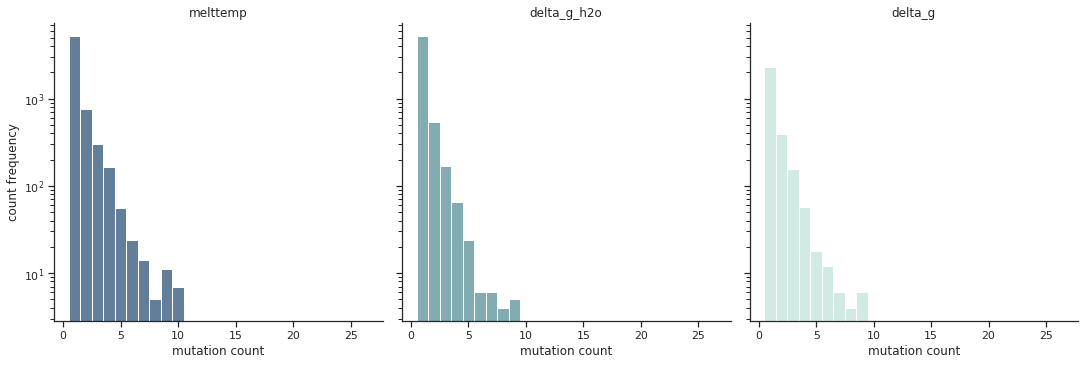

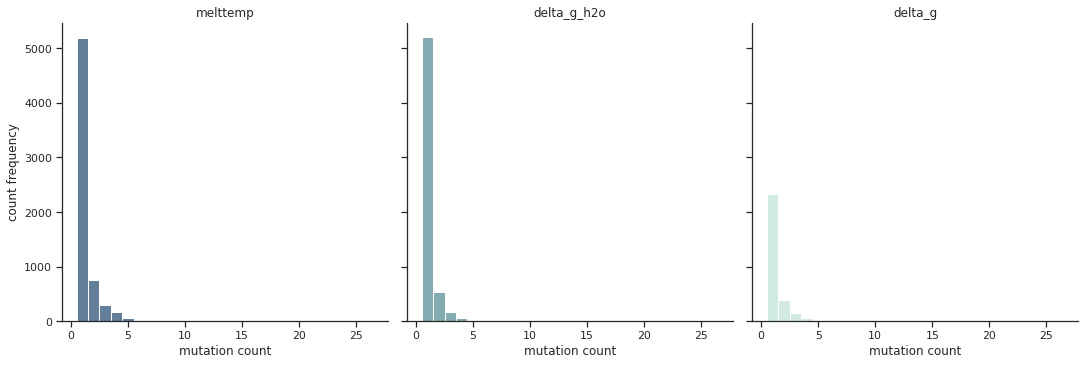

In [52]:
sns.set(style='white')
sns.set_theme(style="ticks")
cmap = sns.cubehelix_palette(3, start=2.8, rot=-.2, as_cmap=False)
cmap[-1] = adjust_lightness(cmap[-1], 2)
order =['melttemp', 'delta_g_h2o', 'delta_g']

for log in [True, False]:  
    g = sns.FacetGrid(data=df, col='delta', hue='delta', height=5, margin_titles=True, palette=cmap, 
                      col_order=order, hue_order=order[::-1])

    g.map_dataframe(sns.histplot, x='MUT_COUNT', log_scale=(False, log), discrete=True)
    g.set_axis_labels('mutation count','count frequency')
    g.set_titles(col_template='{col_name}')


    g.savefig(wd / 'plots' / 'barplot%s.png' % ('_log' if log else ''), dpi=300)

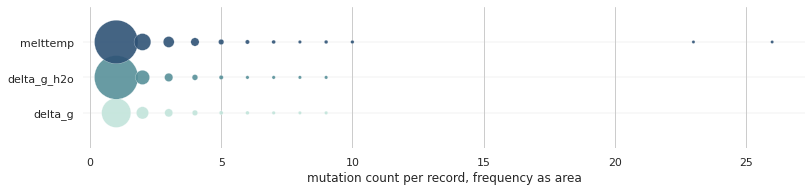

In [68]:
cdf = df.groupby(['MUT_COUNT', 'delta'])['MUT_COUNT'].count().reset_index(name='freq')

sns.set_theme(style="whitegrid")
cmap = sns.cubehelix_palette(3, start=2.8, rot=-.2, as_cmap=False)
cmap[-1] = adjust_lightness(cmap[-1], 2)

g = sns.relplot(
    data=cdf, alpha=.9,
    x="MUT_COUNT", y="delta", 
    size="freq", hue="delta", 
    palette=cmap,
    sizes=(10, 1900),
    height=2.6, aspect=4.4,
    legend=False,
)

g.ax.xaxis.grid(True, "major", linewidth=1)
g.ax.yaxis.grid(True, "major", linewidth=.25)
g.ax.set_ylim(-1, 3)
g.despine(left=True, bottom=True)
g.set_axis_labels('mutation count per record, frequency as area', '')
#g.ax.set_yticklabels(['a','b','c'])
g.savefig(wd / 'plots' / 'dotplot.png', dpi=300)


---
### Comparing dataset sizes and share of redundant sequences

In [376]:
records = [list(fasta) + [len(d)]  for fasta, d in seq_data.items()]
records

[['rep_seq', 'melttemp', 204],
 ['rep_seq', 'delta_g', 74],
 ['rep_seq', 'delta_g_h2o', 147],
 ['full', 'delta_g', 89],
 ['full', 'melttemp', 255],
 ['full', 'delta_g_h2o', 174]]

In [416]:
dt = pd.DataFrame.from_records(records, columns=['set', 'measure', 'size'])
dt

,set,measure,size
0,rep_seq,melttemp,204
1,rep_seq,delta_g,74
2,rep_seq,delta_g_h2o,147
3,full,delta_g,89
4,full,melttemp,255
5,full,delta_g_h2o,174


In [417]:
dt2 = dt.pivot(index='set', columns='measure', values='size').transpose()
dt2.full -= dt2.rep_seq
dt2.columns = ['redundant', 'unique']
dt2 = dt2.reindex(order)
avg = (sum(dt2.redundant) + sum(dt2.unique)) // 3
dt2

,redundant,unique
measure,,
melttemp,51,204
delta_g_h2o,27,147
delta_g,15,74


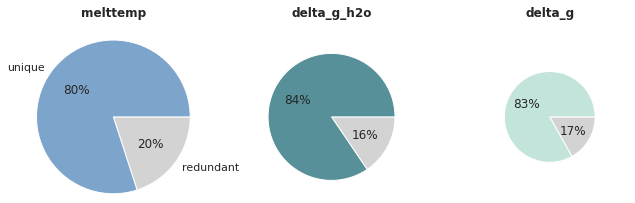

In [418]:
import numpy as np
cmap = sns.cubehelix_palette(3, start=2.8, rot=-.2, as_cmap=False)[::-1]
cmap[0] = adjust_lightness(cmap[0], 4)
vir = sns.color_palette('viridis', 2, as_cmap=False)

fig, ax = plt.subplots(1,3, figsize=(9,3))

ax = ax.flatten()
for i, cat in enumerate(dt2.index):
    dt2.loc[cat].plot.pie(ax=ax[i],
                          autopct='%1.f%%', counterclock=False,
                          labels=['redundant', 'unique'] if cat == 'melttemp' else ['', ''], 
                          startangle=0, 
                          radius=np.sqrt(sum(dt2.loc[cat]) / avg), 
                          colors=['lightgray', cmap[i]])
    ax[i].set_ylabel('')
    ax[i].set_title(cat, fontweight='bold', y=1.1)

#fig.suptitle('relative dataset size for different measurements and share of homologous samples')
fig.tight_layout()
fig.savefig('pies.png', dpi=300)

---
### Annotation Frequency / occurences per UniProt ID

In [419]:
df

,delta,level_1,UniProt_ID,MUTATION,pH,T_(C),MEASURE,METHOD,∆Tm_(C),∆∆G_(kcal/mol),∆∆G_H2O_(kcal/mol),SOURCE,MUT_COUNT
0,delta_g_h2o,0,P03051,C38A C52V,6.3,-,CD,Urea,-,-,-5,UniProt and PDB,2
1,delta_g_h2o,1,P03051,C38A C52A,6.3,-,CD,Urea,-,-,-8.3,UniProt and PDB,2
2,delta_g_h2o,2,P11532,K18N,7.0,-,CD,Urea,-,-,-3.7,UniProt and PDB,1
3,delta_g_h2o,3,P11532,K18N,7.0,-,Fluorescence,Urea,-,-,-3.7,UniProt and PDB,1
4,delta_g_h2o,4,Q8TZE8,W301F,8.0,60,Fluorescence,GdnHCl,-,-,3.98,UniProt and PDB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15513,delta_g,3177,P04637,R175H,7.2,10,Fluorescence,Urea,-,-3.01,-3.01,UniProt and PDB,1
15514,delta_g,3178,P04637,C242S,7.2,10,Fluorescence,Urea,-,-2.94,-2.94,UniProt and PDB,1
15515,delta_g,3179,P04637,R248Q,7.2,10,Fluorescence,Urea,-,-1.94,-1.94,UniProt and PDB,1
15516,delta_g,3180,P04637,R249S,7.2,10,Fluorescence,Urea,-,-1.95,-1.95,UniProt and PDB,1


In [420]:
uniprot = dict()
for row in df.itertuples():
    if row.delta not in uniprot:
        condition_dict = dict()
        uniprot[row.delta] = condition_dict
    else:
        condition_dict = uniprot[row.delta]
    if row.UniProt_ID in condition_dict:
        condition_dict[row.UniProt_ID] |= set(row.MUTATION.strip().split(' '))
    else:
        condition_dict[row.UniProt_ID] = set(row.MUTATION.strip().split(' '))
len(uniprot), sum(len(v) for v in uniprot.values()), max(len(v) for v in uniprot.values())

(3, 520, 256)

In [421]:
for cond, cdict in uniprot.items():
    for _id, idict in cdict.items():
        cdict[_id] = len(idict)
#uniprot

In [422]:
adf = pd.DataFrame.from_dict(uniprot, orient='index', dtype=int).fillna(0).convert_dtypes(convert_integer=True).transpose()
adf = adf.reset_index().rename(columns={'index': 'uniprot'})\
.melt(id_vars='uniprot').set_index('uniprot')\
    .rename(columns={'variable': 'delta', 'value': 'n_mutations'})\
    .sort_values(by='delta', ascending=True)
adf

,delta,n_mutations
uniprot,,
P0ACJ8,delta_g,2
P04637,delta_g,5
P00952,delta_g,0
P08921,delta_g,0
P24821,delta_g,5
...,...,...
P24297,melttemp,4
Q7SIG1,melttemp,1
P53779,melttemp,3


<ipython-input-423-4cdc466e1bc4>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.ax.set_xticklabels([toggle_label_on_size(l, 80) for l in g.ax.get_xticklabels()], rotation=90, fontsize=5)


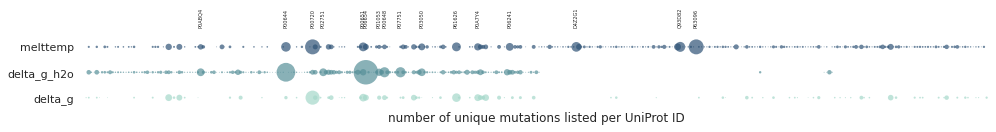

In [423]:

def toggle_label_on_size(lab, min_size):
    uniprot = lab.get_text()
    if max(adf.at[uniprot, 'n_mutations']) > min_size:
        return uniprot
    else:
        return ''


sns.set_theme(style="white")
cmap = sns.cubehelix_palette(3, start=2.8, rot=-.2, as_cmap=False)
cmap[-1] = adjust_lightness(cmap[-1], 2)
cmap[0] = adjust_lightness(cmap[0], .9)


g = sns.relplot(
    data=adf, alpha=.7,
    x="uniprot", y="delta",
    size="n_mutations", hue="delta", 
    palette=cmap,
    sizes=(0, 600),
    height=2, aspect=7,
    legend=False,
)

g.set(ylabel='', xlabel='number of unique mutations listed per UniProt ID')  #, xticklabels=[])
g.ax.xaxis.tick_top()
g.ax.tick_params(top=False)
g.ax.set_xticklabels([toggle_label_on_size(l, 80) for l in g.ax.get_xticklabels()], rotation=90, fontsize=5)
g.ax.set_ylim(-0.4, 2.4)
g.ax.set_xlim(-1, 339)
g.despine(left=True, bottom=True)
g.tight_layout()
g.savefig('dotplot_nmuts.png', dpi=300)

In [428]:
# also bind the sequence length to the adf DataFrame
def get_len(uniprot_id, measure):
    if uniprot_id in seq_data[('full', measure)]:
        return len(seq_data[('full', measure)][uniprot_id])
    else:
        try:
            return len(seq_data[('rep_seq', measure)][uniprot_id])
        except KeyError:
            return 0
adf

,delta,n_mutations,len
uniprot,,,
P0ACJ8,delta_g,2,210
P04637,delta_g,5,393
P00952,delta_g,0,0
P08921,delta_g,0,0
P24821,delta_g,5,2201
...,...,...,...
P24297,melttemp,4,54
Q7SIG1,melttemp,1,310
P53779,melttemp,3,464


In [429]:
adf['len'] = [get_len(i, d) for i, d in zip(adf.index, adf.delta)]
adf

,delta,n_mutations,len
uniprot,,,
P0ACJ8,delta_g,2,210
P04637,delta_g,5,393
P00952,delta_g,0,0
P08921,delta_g,0,0
P24821,delta_g,5,2201
...,...,...,...
P24297,melttemp,4,54
Q7SIG1,melttemp,1,310
P53779,melttemp,3,464


In [430]:
max(adf.at['P25440','len'])


801

<ipython-input-431-98a3a462729a>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.ax.set_xticklabels([toggle_label_on_size(l, 960) for l in g.ax.get_xticklabels()], rotation=90, fontsize=5)


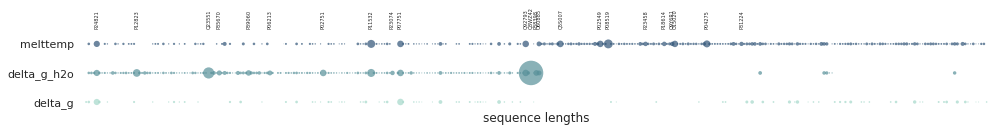

In [431]:
#%matplotlib widget

def toggle_label_on_size(lab, min_size):
    uniprot = lab.get_text()
    if max(adf.at[uniprot, 'len']) > min_size:
        return uniprot
    else:
        return ''

sns.set_theme(style="white")
cmap = sns.cubehelix_palette(3, start=2.8, rot=-.2, as_cmap=False)
cmap[-1] = adjust_lightness(cmap[-1], 2)
cmap[0] = adjust_lightness(cmap[0], .9)

g = sns.relplot(
    data=adf, alpha=.7,
    x="uniprot", y="delta",
    size="len", hue="delta", 
    palette=cmap,
    sizes=(0, 600),
    height=2, aspect=7,
    legend=False,
)
# insert code chunk below here

g.set(ylabel='', xlabel='sequence lengths')
g.ax.xaxis.tick_top()
g.ax.tick_params(top=False)
g.ax.set_xticklabels([toggle_label_on_size(l, 960) for l in g.ax.get_xticklabels()], rotation=90, fontsize=5)
g.ax.set_ylim(-0.2, 2.2)
g.ax.set_xlim(-1, 339)
g.despine(left=True, bottom=True)
g.tight_layout()
g.savefig('dotplot_nmuts_seqLen.png', dpi=300)

In [41]:
annot = g.ax.annotate("", xy=(1,1), xytext=(1,1),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):
    print(ind)

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                           " ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    print(event)
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

In [432]:
df

,delta,level_1,UniProt_ID,MUTATION,pH,T_(C),MEASURE,METHOD,∆Tm_(C),∆∆G_(kcal/mol),∆∆G_H2O_(kcal/mol),SOURCE,MUT_COUNT
0,delta_g_h2o,0,P03051,C38A C52V,6.3,-,CD,Urea,-,-,-5,UniProt and PDB,2
1,delta_g_h2o,1,P03051,C38A C52A,6.3,-,CD,Urea,-,-,-8.3,UniProt and PDB,2
2,delta_g_h2o,2,P11532,K18N,7.0,-,CD,Urea,-,-,-3.7,UniProt and PDB,1
3,delta_g_h2o,3,P11532,K18N,7.0,-,Fluorescence,Urea,-,-,-3.7,UniProt and PDB,1
4,delta_g_h2o,4,Q8TZE8,W301F,8.0,60,Fluorescence,GdnHCl,-,-,3.98,UniProt and PDB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15513,delta_g,3177,P04637,R175H,7.2,10,Fluorescence,Urea,-,-3.01,-3.01,UniProt and PDB,1
15514,delta_g,3178,P04637,C242S,7.2,10,Fluorescence,Urea,-,-2.94,-2.94,UniProt and PDB,1
15515,delta_g,3179,P04637,R248Q,7.2,10,Fluorescence,Urea,-,-1.94,-1.94,UniProt and PDB,1
15516,delta_g,3180,P04637,R249S,7.2,10,Fluorescence,Urea,-,-1.95,-1.95,UniProt and PDB,1


---
### pH distribution

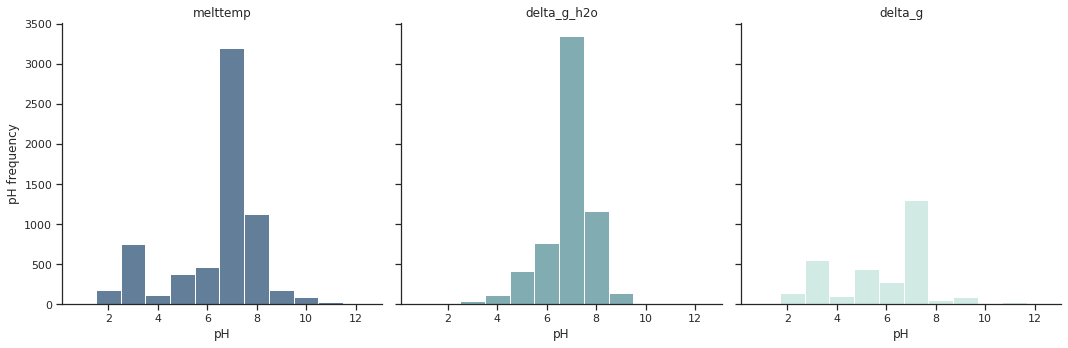

In [433]:
sns.set(style='white')
sns.set_theme(style="ticks")
cmap = sns.cubehelix_palette(3, start=2.8, rot=-.2, as_cmap=False)
cmap[-1] = adjust_lightness(cmap[-1], 2)
order =['melttemp', 'delta_g_h2o', 'delta_g']


g = sns.FacetGrid(data=df, col='delta', hue='delta', height=5, margin_titles=True, palette=cmap, 
                  col_order=order, hue_order=order[::-1])

g.map_dataframe(sns.histplot, x='pH', log_scale=False, discrete=True)
g.set_axis_labels('pH','pH frequency')
g.set_titles(col_template='{col_name}')

g.tight_layout()
g.savefig('pH_barplot.png', dpi=300)

---
### temperature distribution

In [434]:
df.at[df['T_(C)'] == '-', 'T_(C)'] = -100
df['temp'] = df['T_(C)'].astype(float)
df = df.sort_values(by='delta', ascending=True)
print(sorted(df.temp.unique()))
df

[-100.0, -15.0, 0.0, 4.0, 5.0, 10.0, 14.0, 15.0, 16.0, 20.0, 20.15, 21.5, 22.0, 23.0, 24.0, 25.0, 25.15, 25.2, 25.8, 27.0, 28.0, 28.5, 30.0, 35.0, 37.0, 38.5, 38.6, 38.75, 38.8, 39.0, 39.5, 39.6, 39.8, 40.0, 40.2, 40.4, 40.7, 40.75, 40.8, 40.9, 41.0, 41.4, 41.47, 41.9, 42.0, 42.7, 43.2, 43.4, 44.0, 44.2, 44.3, 45.0, 45.8, 45.9, 46.0, 46.16, 46.2, 46.5, 46.6, 47.0, 47.2, 47.3, 47.8, 47.9, 48.0, 48.4, 48.6, 49.0, 49.2, 49.8, 50.0, 50.1, 50.2, 50.4, 50.6, 50.8, 50.9, 51.1, 51.2, 51.4, 51.5, 51.55, 51.6, 51.65, 51.68, 51.7, 51.76, 51.8, 52.0, 52.1, 52.2, 52.5, 52.6, 52.7, 53.0, 53.08, 53.1, 53.36, 53.4, 53.42, 53.56, 53.6, 54.1, 54.6, 55.0, 55.6, 56.2, 57.0, 57.1, 57.5, 57.8, 58.0, 58.8, 59.0, 60.0, 61.0, 61.1, 61.4, 61.6, 61.7, 61.8, 61.9, 62.2, 62.4, 62.6, 62.8, 62.9, 63.0, 63.2, 63.3, 63.4, 63.6, 63.9, 64.3, 64.5, 64.6, 64.7, 64.88, 64.89, 64.9, 65.0, 65.09, 65.1, 65.15, 65.2, 65.3, 65.4, 65.5, 65.6, 65.7, 66.0, 66.1, 66.2, 66.3, 66.4, 66.48, 66.51, 66.7, 67.2, 68.8, 69.0, 69.5, 70.0, 7

,delta,level_1,UniProt_ID,MUTATION,pH,T_(C),MEASURE,METHOD,∆Tm_(C),∆∆G_(kcal/mol),∆∆G_H2O_(kcal/mol),SOURCE,MUT_COUNT,temp
15517,delta_g,3181,P04637,R273H,7.20,10,Fluorescence,Urea,-,-0.35,-0.35,UniProt and PDB,1,10.0
13541,delta_g,993,P61626,G145A,2.70,64.9,DSC,Thermal,-,-0.55,-,UniProt,1,64.9
13540,delta_g,992,P61626,G123A,2.70,64.9,DSC,Thermal,-,-0.62,-,UniProt,1,64.9
13539,delta_g,991,P61626,G90A,2.70,64.9,DSC,Thermal,-,-0.36,-,UniProt,1,64.9
13538,delta_g,990,P61626,G86A,2.70,64.9,DSC,Thermal,-,-0.12,-,UniProt,1,64.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9186,melttemp,3212,P61626,I124V,2.70,-100,DSC,Thermal,-5.6,-,-,UniProt,1,-100.0
9187,melttemp,3213,P61626,V111A,2.70,-100,DSC,Thermal,-4.0,-,-,UniProt,1,-100.0
9188,melttemp,3214,P61626,V139A,3.14,-100,DSC,Thermal,-7.7,-,-,UniProt,1,-100.0
9190,melttemp,3216,P61626,Y38F,2.70,-100,DSC,Thermal,-1.5,-,-,UniProt,1,-100.0


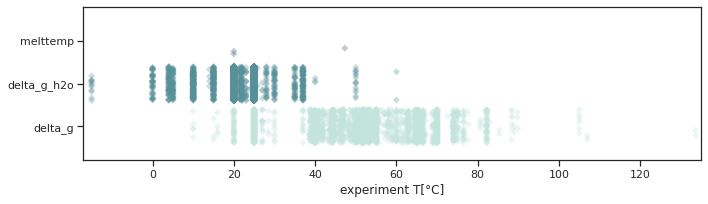

In [435]:
sns.set(style='white')
sns.set_theme(style="ticks")
cmap = sns.cubehelix_palette(3, start=2.8, rot=-.2, as_cmap=False)
cmap[-1] = adjust_lightness(cmap[-1], 2)
order =['melttemp', 'delta_g_h2o', 'delta_g']


fig, ax = plt.subplots(1,1, figsize=(10,3))
f = sns.stripplot(data=df, hue='delta', x='temp', y='delta', 
                  alpha=.3, palette=cmap, order=order[::-1], 
                  marker='D', jitter=.4)

f.set(ylabel='', xlabel='experiment T[°C]')
plt.legend([], [], frameon=False)
ax.set_ylim(-0.8, 2.8)
ax.set_xlim(-17, 135)
fig.tight_layout()

fig.savefig('temp_stripplot.png', dpi=300)

---
### substitution matrix

In [440]:
amino_acids = list('ARNDCQEGHILKMFPSTWYV')
matrix = np.zeros((20,20))
errors = list()

for mstr in df.MUTATION:
    ms = mstr.split(' ')
    for m in ms:
        if m == '':
            continue
        m = m.split(':')[-1]
        try:
            x,y = [amino_acids.index(c) for c in m[0::len(m)-1]]
            matrix[y,x] += 1
            matrix[x,y] += 1
        except ValueError as ve:
            errors.append(m)
            print(m, ms, ve)
matrix = np.flipud(matrix)
print(errors)

K1943 ['R191A', 'K1943'] '3' is not in list
I3) ['I3)'] ')' is not in list
I3) ['I3)'] ')' is not in list
L33) ['L33)'] ')' is not in list
I24) ['I24)'] ')' is not in list
I3) ['I3)'] ')' is not in list
I3) ['I3)'] ')' is not in list
E93) ['E82E', 'Q47K', 'E63K', 'Q84K', 'S89K', 'E93)'] ')' is not in list
D94) ['H66E', 'S89K', 'M91K', 'D94)'] ')' is not in list
D139) ['D139)'] ')' is not in list
D140) ['N135H', 'D140)'] ')' is not in list
D139) ['N135H', 'D139)'] ')' is not in list
D140) ['N135H', 'D140)'] ')' is not in list
D139) ['N135H', 'D139)'] ')' is not in list
D139) ['N135H', 'D139)'] ')' is not in list
D140) ['D140)'] ')' is not in list
D139) ['D139)'] ')' is not in list
D140) ['D140)'] ')' is not in list
D139) ['N135H', 'D139)'] ')' is not in list
D140) ['N135H', 'D140)'] ')' is not in list
G443) ['G443)'] ')' is not in list
G291) ['G291)'] ')' is not in list
N235) ['N235)'] ')' is not in list
G130) ['G130)'] ')' is not in list
D140) ['N135H', 'D140)'] ')' is not in list
D139

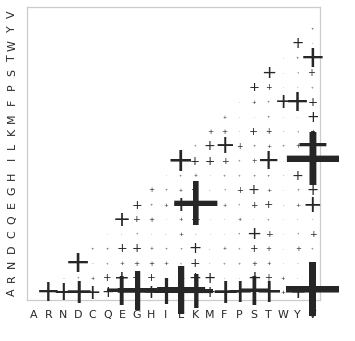

In [442]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(5,5))

mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True

g = sns.heatmap(matrix, mask=np.flipud(mask), square=True, 
                alpha=0,
                linewidths=.5, linecolor='black',
                xticklabels=amino_acids,
                yticklabels=amino_acids[::-1],
                cbar=False,
               )

for edge, spine in ax.spines.items():
    spine.set_visible(True)          

m = pd.DataFrame(matrix)
for i, c in enumerate(m.columns):
    for j, v in enumerate(m[c]):
        if i + j < 20:
            continue
        ax.text(i + 0.5, j + 0.5, '+', size=v/10, ha='center', va='center')
f.tight_layout()
f.savefig('mut_freq.png', dpi=300)